In [32]:
import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader

data preprocessing

In [33]:
class CelebADataset(Dataset):
    def __init__(self, image_dir, transform=None, max_samples=140000):
        self.image_dir = image_dir
        self.image_filenames = sorted(os.listdir(image_dir))[:max_samples]
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

data_path = r"E:\datasets\archive\img_align_celeba\img_align_celeba"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = CelebADataset(data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


visualizing the inputs

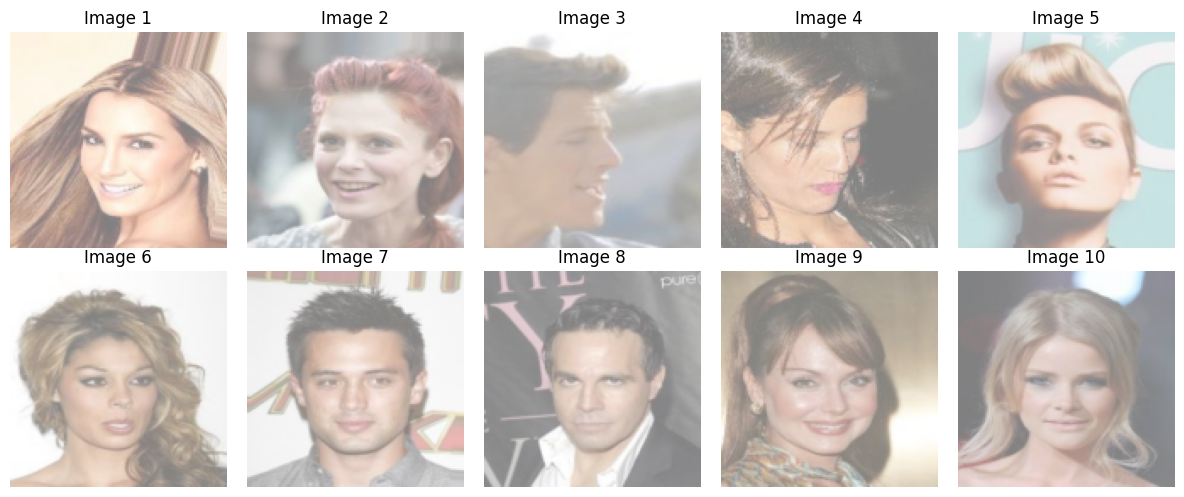

In [34]:
import matplotlib.pyplot as plt
import torch

mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    img = dataset[i]
    if not torch.is_floating_point(img):
        img = img.float()

    img = img * std + mean
    img = img.clamp(0, 1)

    img_np = img.permute(1, 2, 0).numpy()
    
    ax = axes[i // 5, i % 5]
    ax.imshow(img_np)
    ax.axis('off')
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()


VAE architecture

In [36]:
# we have to replace this
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 256 * 8 * 8)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_decode(z).view(z.size(0), 256, 8, 8)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar, z

    def loss_function(self, x, x_recon, mu):
        recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')

        
        mu_centered = mu - mu.mean(dim=0)
        cov = (mu_centered.T @ mu_centered) / mu.size(0)

        diag = torch.diag(cov)
        off_diag = cov - torch.diag_embed(diag)

        lambda_diag = 10.0
        lambda_offdiag = 5.0

        loss_diag = torch.sum((diag - 1.0) ** 2)
        loss_offdiag = torch.sum(off_diag ** 2)

        dip_loss = lambda_diag * loss_diag + lambda_offdiag * loss_offdiag
        loss = recon_loss + dip_loss
        return loss, recon_loss, dip_loss


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


training vae model

In [38]:
import torch
from torch import optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 16
model = VAE(latent_dim).to(device)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = CelebADataset(data_path, transform=transform, max_samples=147000)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
model.train()
for epoch in range(epochs):
    total_loss = 0
    for x in tqdm(dataloader):
        x = x.to(device)
        x_recon, z_mean, z_log_var, z = model(x)
        
        # Use z_mean for DIP-VAE loss
        total_loss_tensor, recon_loss_tensor, latent_reg_tensor = model.loss_function(x, x_recon, z_mean)

        optimizer.zero_grad()
        total_loss_tensor.backward()
        optimizer.step()

        total_loss += total_loss_tensor.item()

    avg_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")
    
print(f"Epoch {epoch + 1}, Total Loss: {avg_loss:.4f}, Recon Loss: {recon_loss_tensor.item():.2f}, DIP Loss: {latent_reg_tensor.item():.2f}")



100%|██████████| 2297/2297 [1:48:07<00:00,  2.82s/it]


Epoch 1, Loss: 27036.5809


100%|██████████| 2297/2297 [1:13:17<00:00,  1.91s/it]


Epoch 2, Loss: 25797.6780


100%|██████████| 2297/2297 [25:12<00:00,  1.52it/s]


Epoch 3, Loss: 25743.9814


100%|██████████| 2297/2297 [03:51<00:00,  9.94it/s]


Epoch 4, Loss: 25712.8492


100%|██████████| 2297/2297 [03:48<00:00, 10.04it/s]


Epoch 5, Loss: 25690.8661


100%|██████████| 2297/2297 [03:48<00:00, 10.03it/s]


Epoch 6, Loss: 25672.5188


100%|██████████| 2297/2297 [03:49<00:00, 10.00it/s]


Epoch 7, Loss: 25661.0385


100%|██████████| 2297/2297 [03:47<00:00, 10.12it/s]


Epoch 8, Loss: 25648.8862


100%|██████████| 2297/2297 [03:48<00:00, 10.06it/s]


Epoch 9, Loss: 25638.6449


100%|██████████| 2297/2297 [03:46<00:00, 10.14it/s]

Epoch 10, Loss: 25629.4175
Epoch 10, Total Loss: 25629.4175, Recon Loss: 1450045.75, DIP Loss: 96.51


In [39]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def traverse_smile(model, dataloader, device, smile_dim=5, steps=9, delta=3.0):
    model.eval()

    # Select a single image (neutral or sad face)
    for x in dataloader:
        x = x.to(device)
        with torch.no_grad():
            _, mu, _, _ = model(x[:1])  # Take 1 image from the batch
        break

    mu = mu[0].detach().cpu().numpy()  # shape: (latent_dim,)
    fig, axes = plt.subplots(1, steps, figsize=(steps * 2, 2))

    # Generate values for smile_dim
    values = np.linspace(-delta, delta, steps)

    for i, val in enumerate(values):
        z = mu.copy()
        z[smile_dim] = val  # Only change smile dimension
        z_tensor = torch.tensor(z, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            recon = model.decode(z_tensor)[0].permute(1, 2, 0).cpu().numpy()

        axes[i].imshow(recon)
        axes[i].axis('off')
        axes[i].set_title(f'z[{smile_dim}]={val:.1f}', fontsize=8)

    plt.suptitle("Latent Traversal - Smile Attribute", fontsize=14)
    plt.tight_layout()
    plt.show()


Traversing latent dim 0


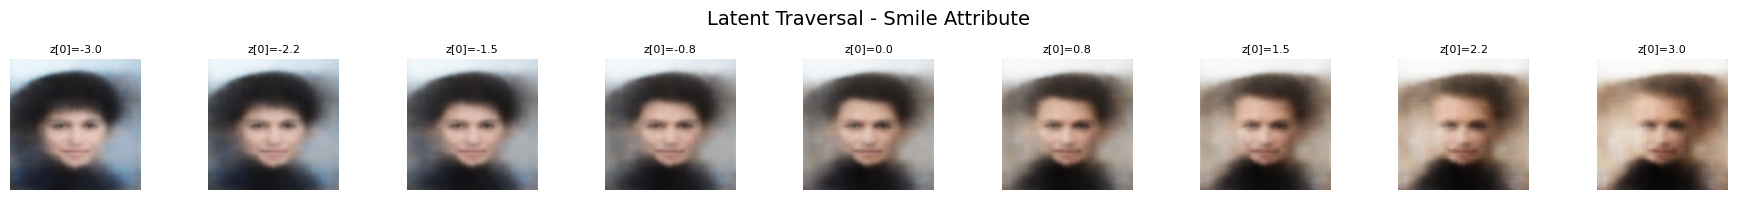

Traversing latent dim 1


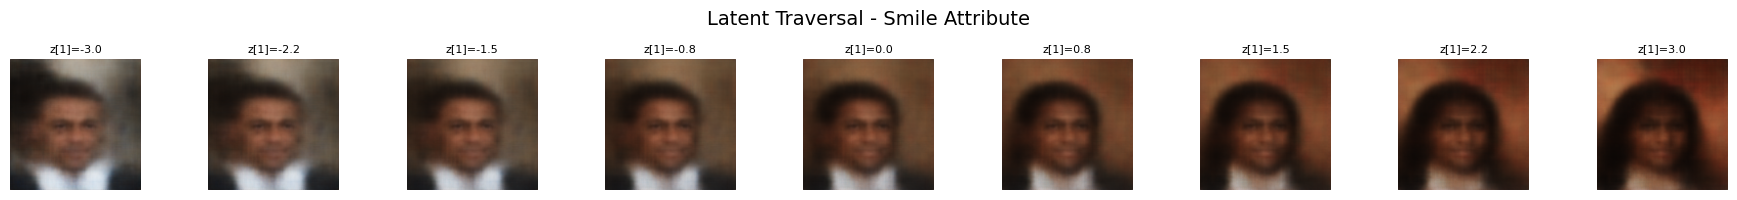

Traversing latent dim 2


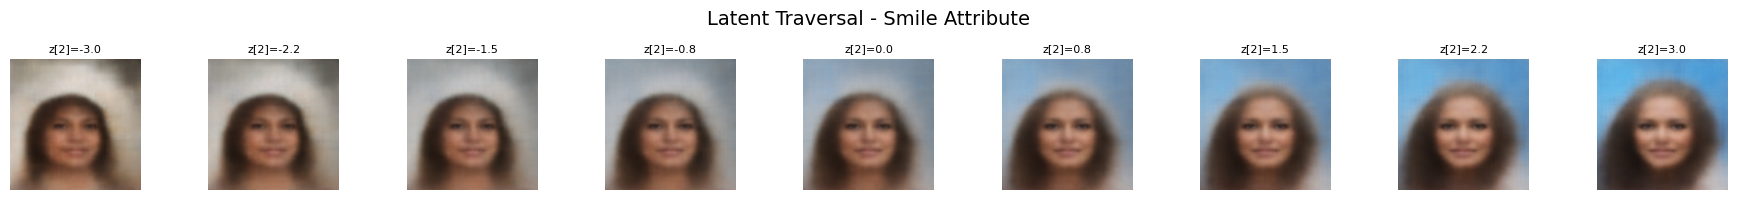

Traversing latent dim 3


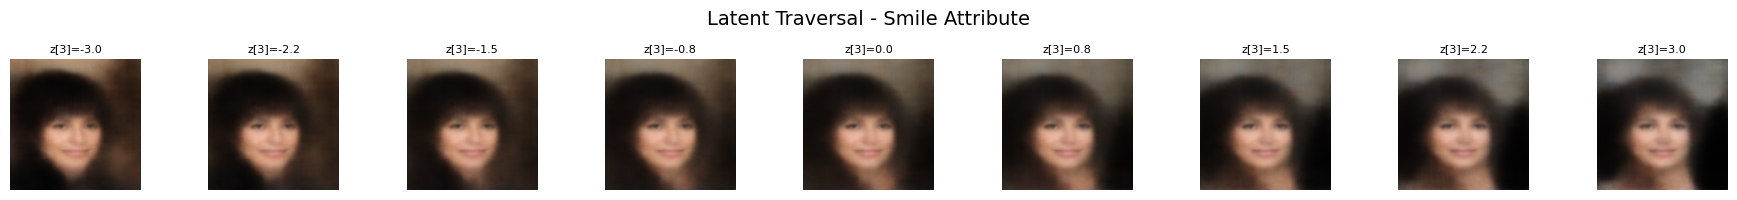

Traversing latent dim 4


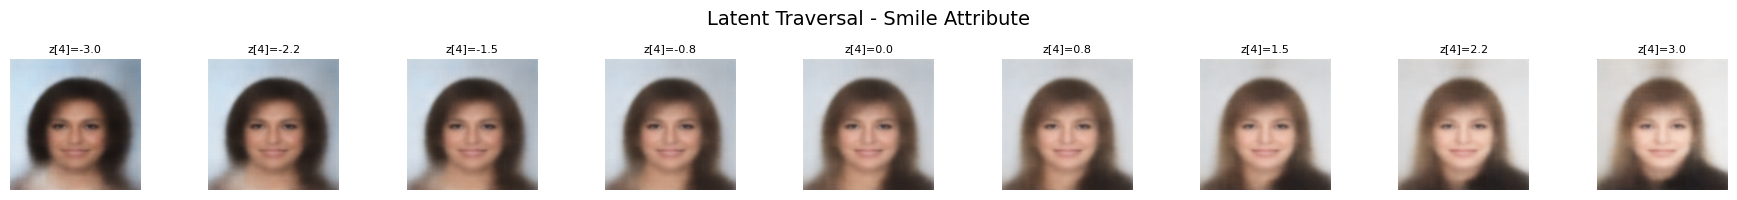

Traversing latent dim 5


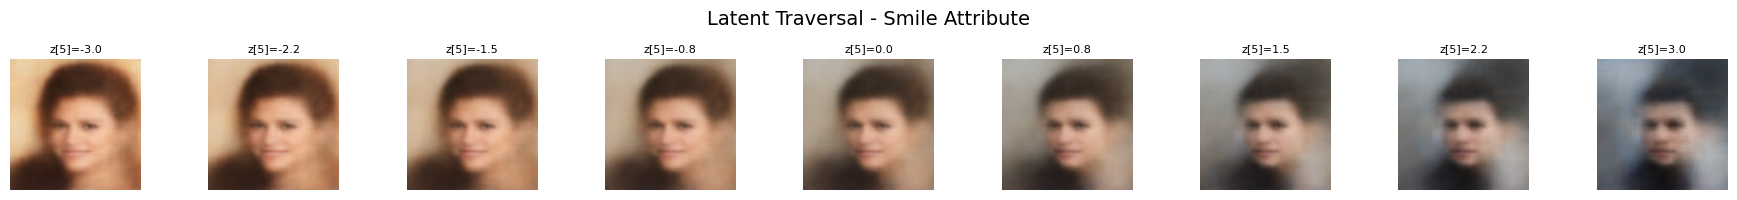

Traversing latent dim 6


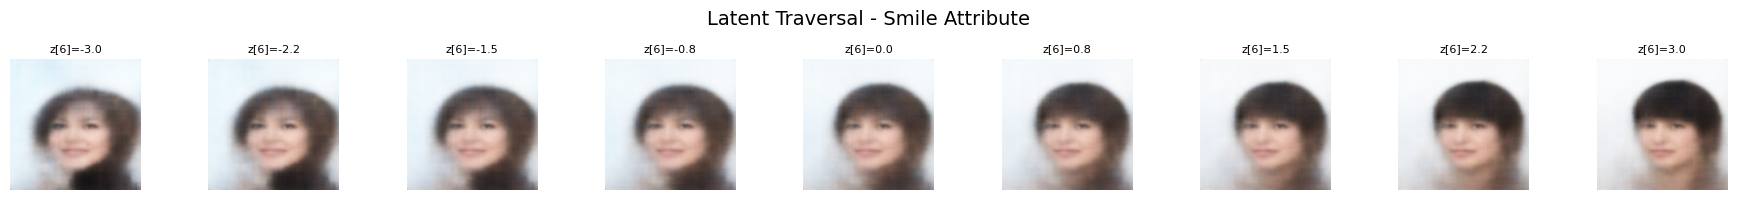

Traversing latent dim 7


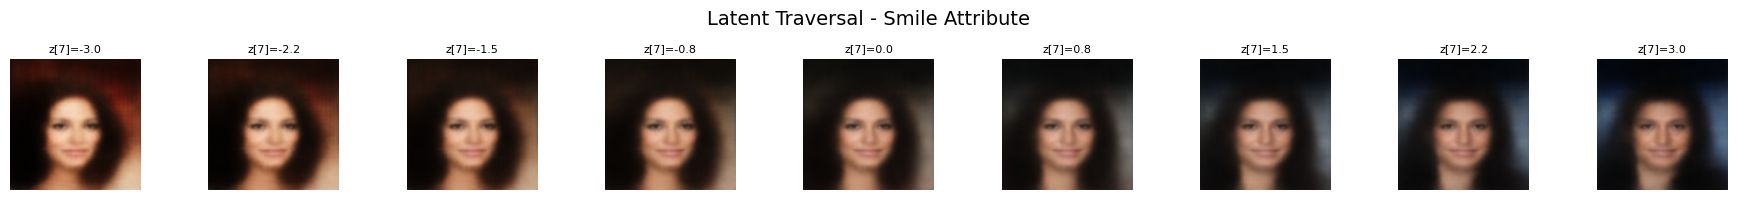

Traversing latent dim 8


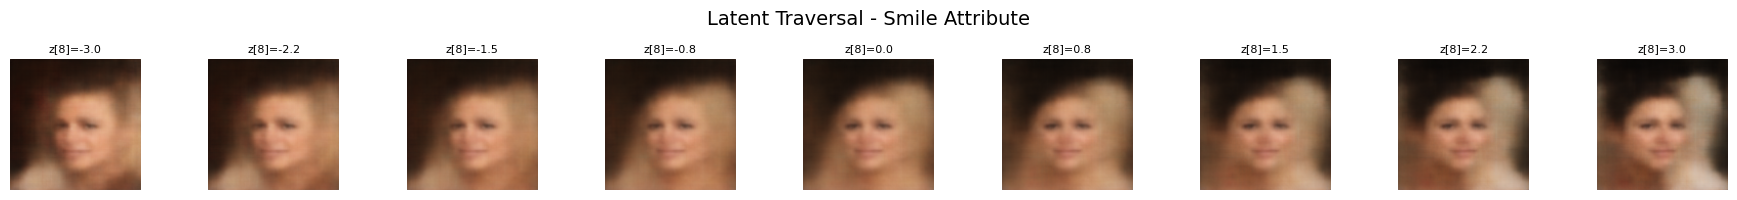

Traversing latent dim 9


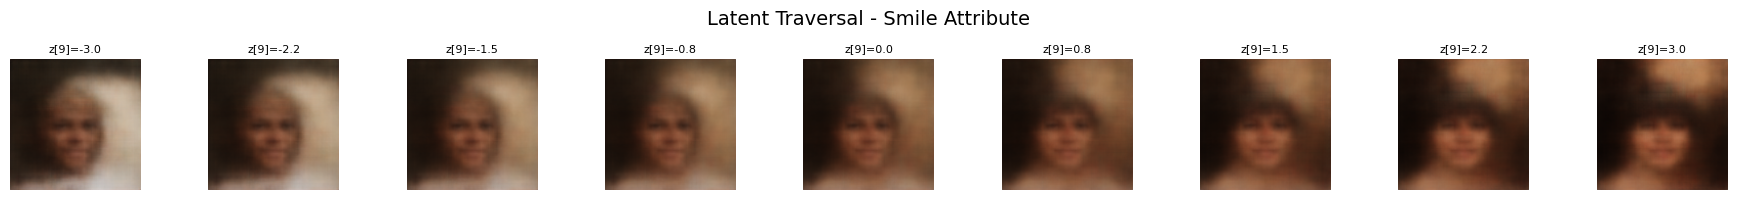

Traversing latent dim 10


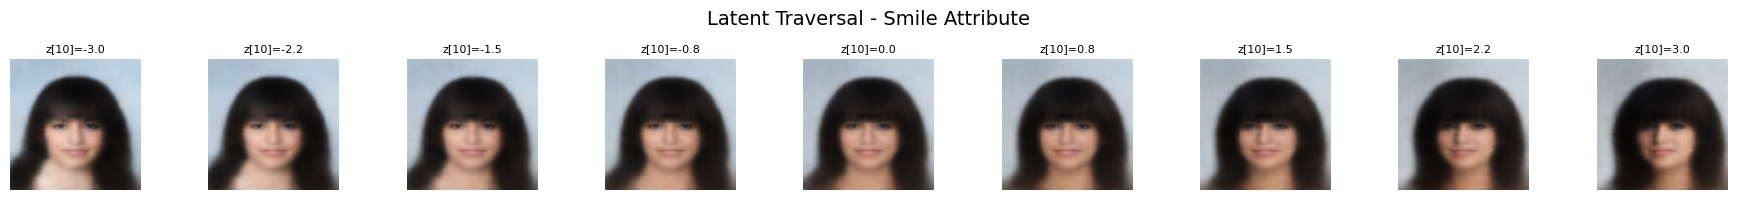

Traversing latent dim 11


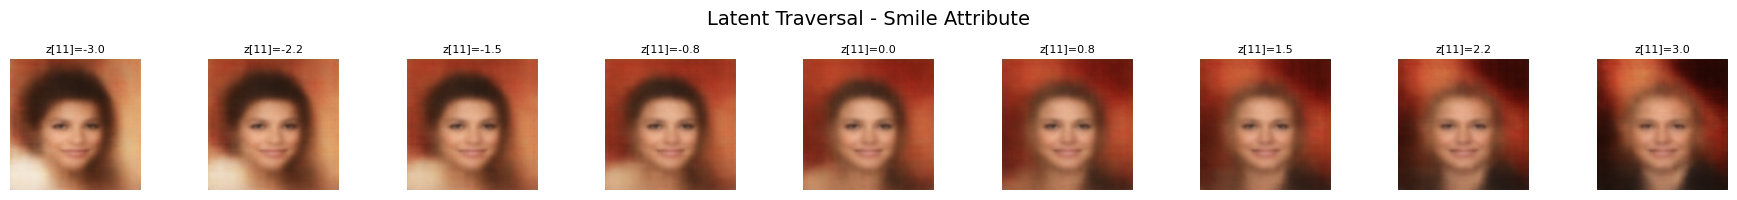

Traversing latent dim 12


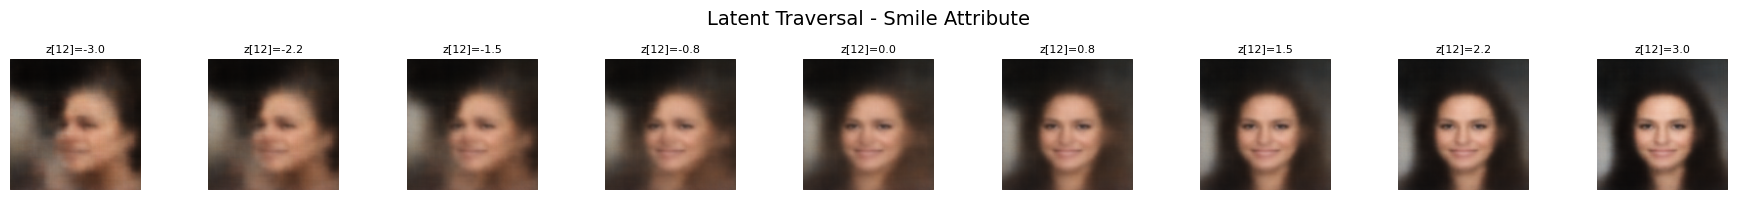

Traversing latent dim 13


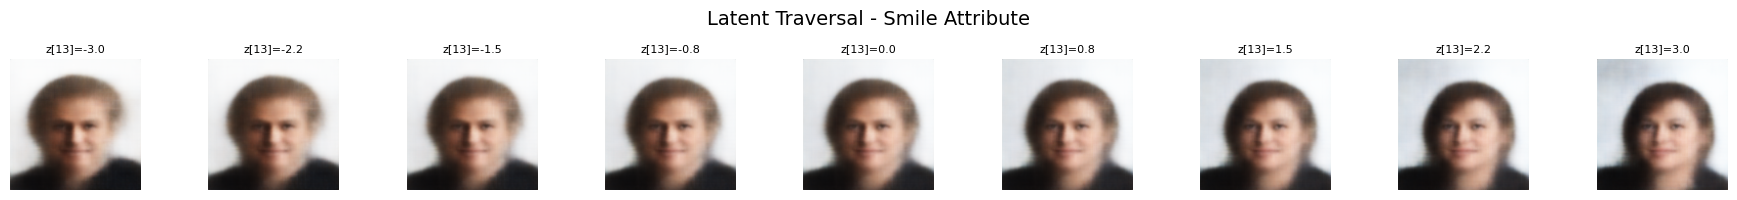

Traversing latent dim 14


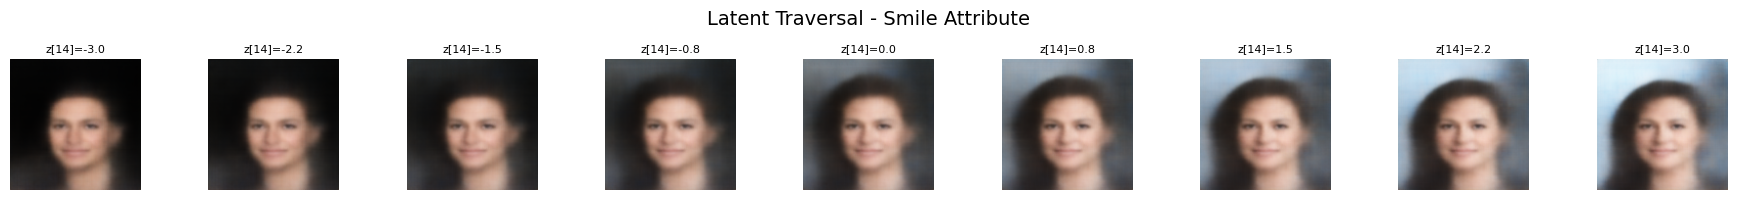

Traversing latent dim 15


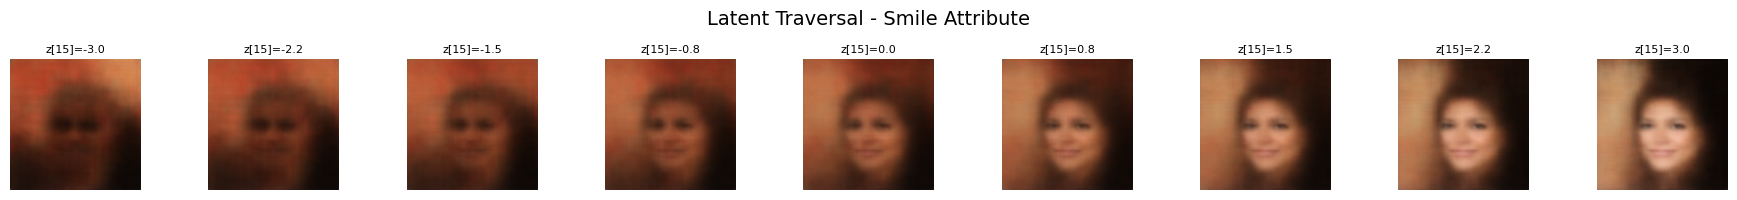

In [40]:
#checking all latent space
for dim in range(latent_dim):
    print(f"Traversing latent dim {dim}")
    traverse_smile(model, dataloader, device, smile_dim=dim)


In [41]:
#attrbute correlation
import pandas as pd

def find_smile_latent_dim(model, dataloader, smile_labels, device, latent_dim):
    model.eval()
    all_mu = []
    all_labels = []

    with torch.no_grad():
        for i, x in enumerate(dataloader):
            x = x.to(device)
            _, mu, _, _ = model(x)
            all_mu.append(mu.cpu())
            all_labels.extend(smile_labels[i * len(x):(i+1) * len(x)])
            if len(all_labels) >= 5000:
                break

    all_mu = torch.cat(all_mu).numpy()
    all_labels = np.array(all_labels[:len(all_mu)])

    correlations = np.corrcoef(all_mu.T, all_labels)[-1, :-1]
    ranked_dims = np.argsort(-np.abs(correlations))  # highest abs correlation
    return correlations, ranked_dims


visualizing latent traversal, keeping one latent dim and others fixed for the 16 latent dim used

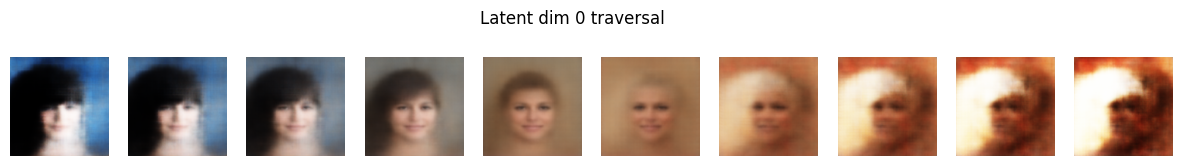

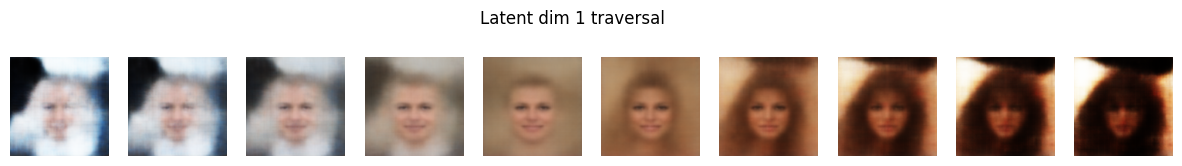

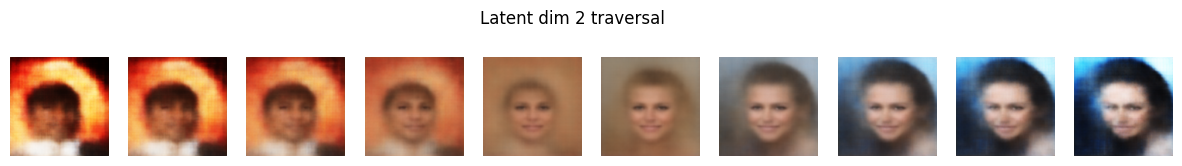

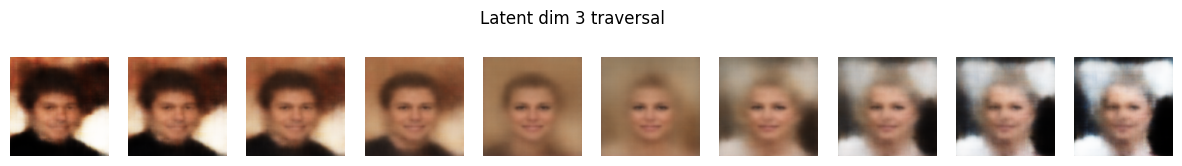

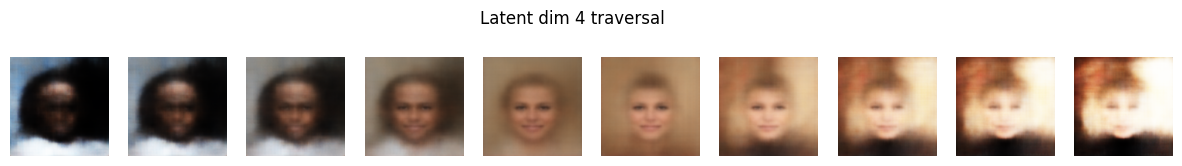

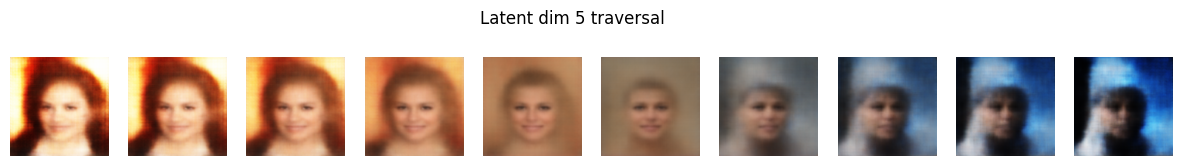

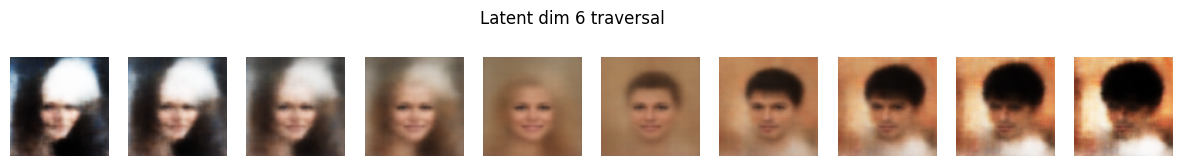

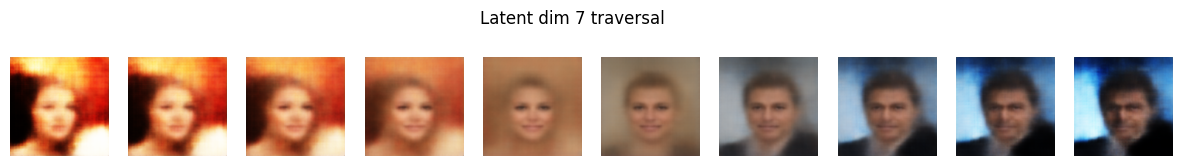

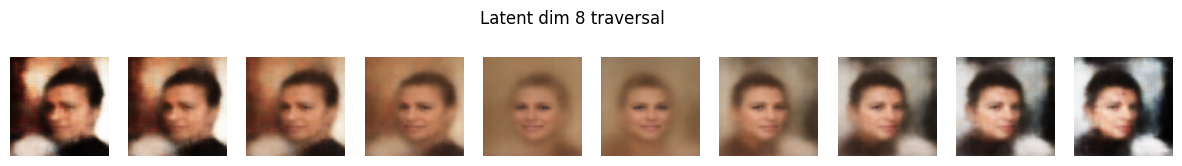

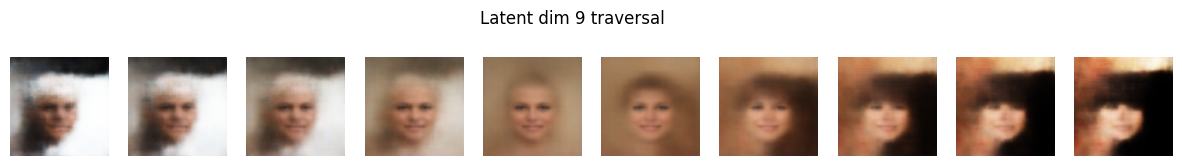

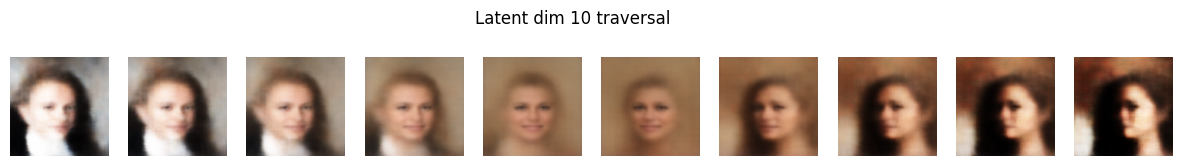

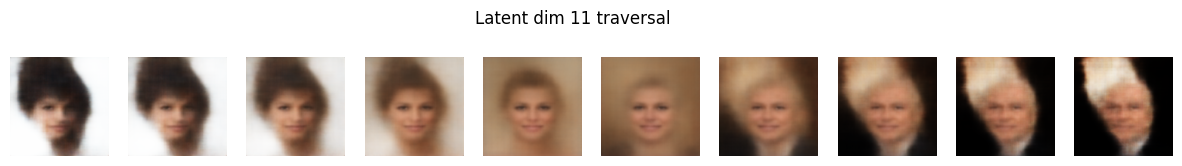

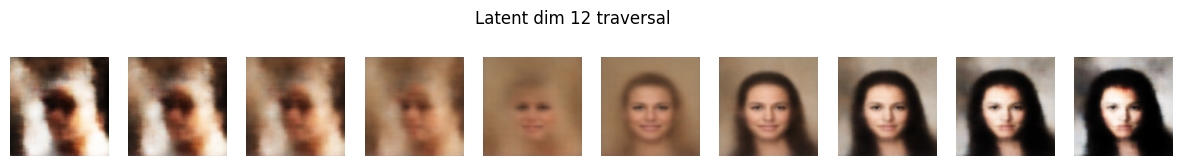

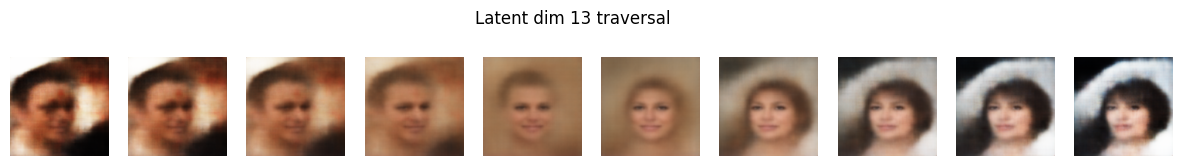

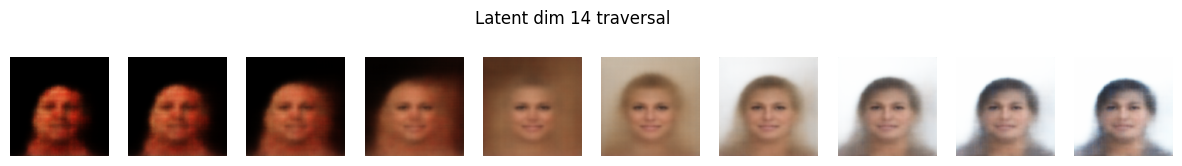

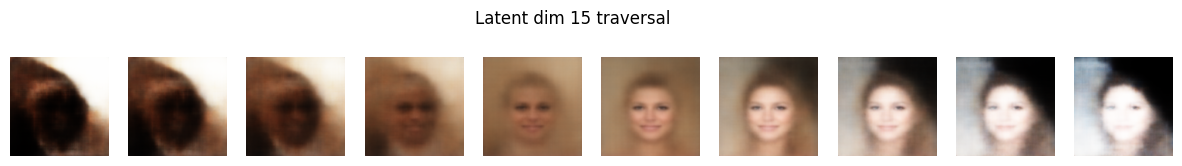

In [42]:
import matplotlib.pyplot as plt

def visualize_latent_traversal(model, latent_dim, steps=9, scale=3):
    model.eval()
    with torch.no_grad():
        z = torch.zeros((steps, latent_dim)).to(device)

        for dim in range(latent_dim):
            z_traversal = torch.zeros((steps, latent_dim)).to(device)
            values = torch.linspace(-scale, scale, steps).to(device)
            z_traversal[:, dim] = values
            generated = model.decode(z_traversal).cpu()

            fig, axes = plt.subplots(1, steps, figsize=(15, 2))
            for i in range(steps):
                img = generated[i].clamp(0, 1).permute(1, 2, 0).numpy()
                axes[i].imshow(img)
                axes[i].axis('off')
            fig.suptitle(f"Latent dim {dim} traversal")
            plt.show()

visualize_latent_traversal(model, latent_dim, steps=10, scale=10)

1).Continuous Interpolation

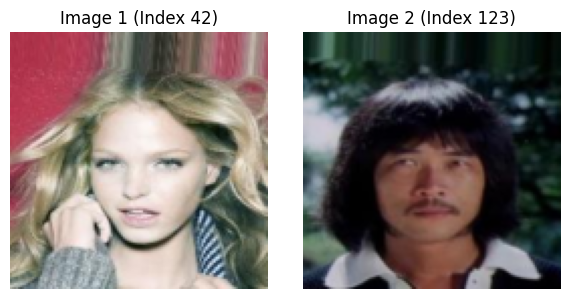

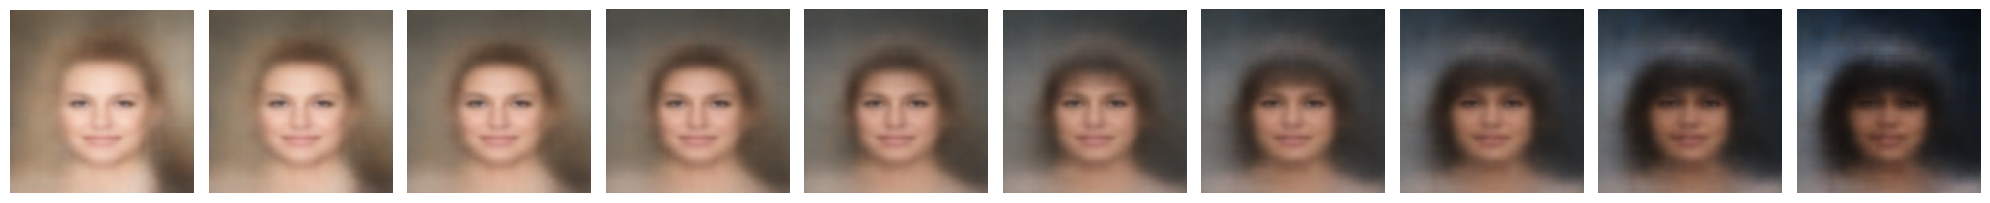

In [43]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def interpolate(z1, z2, steps=10):
    return [(1 - alpha) * z1 + alpha * z2 for alpha in np.linspace(0, 1, steps)]

def plot_interpolations(model, img1, img2, steps=10):
    model.eval()
    with torch.no_grad():
        z1_mean, _ = model.encode(img1.unsqueeze(0).to(device))
        z2_mean, _ = model.encode(img2.unsqueeze(0).to(device))
        interpolated_z = interpolate(z1_mean.squeeze(), z2_mean.squeeze(), steps)
        interpolated_imgs = [model.decode(z.unsqueeze(0)).squeeze().cpu() for z in interpolated_z]

    fig, axs = plt.subplots(1, steps, figsize=(20, 3))
    for i, img in enumerate(interpolated_imgs):
        axs[i].imshow(img.permute(1, 2, 0).clamp(0, 1))
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()
img1 = dataset[15639]
img2 = dataset[25489]
def show_img(img_tensor, title=""):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)

plt.figure(figsize=(6,3))
plt.subplot(1, 2, 1)
show_img(img1, title="Image 1 (Index 42)")
plt.subplot(1, 2, 2)
show_img(img2, title="Image 2 (Index 123)")
plt.tight_layout()
plt.show()
plot_interpolations(model, img1, img2, steps=10)

2).Style-Preserving Content Transfer

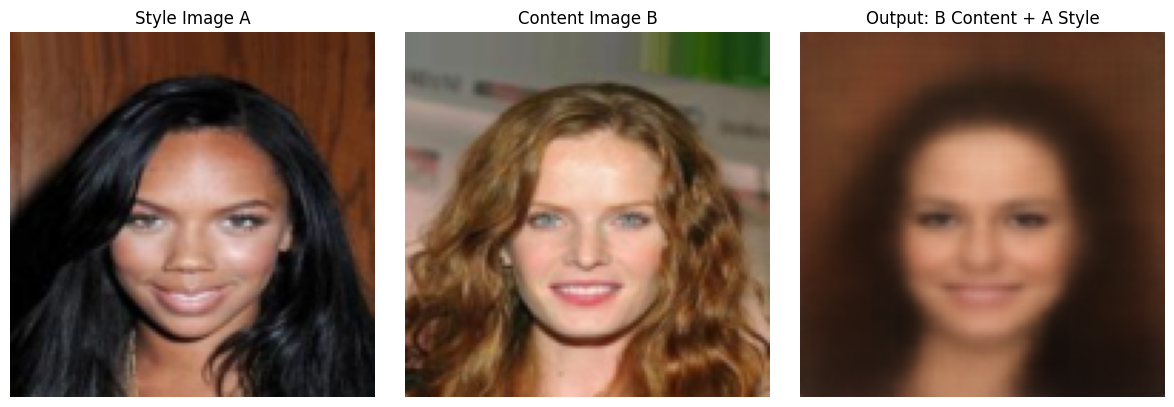

In [44]:
import torch
import matplotlib.pyplot as plt

def style_preserving_transfer(model, dataloader, device):
    model.eval()

    data_iter = iter(dataloader)
    batch1 = next(data_iter)
    batch2 = next(data_iter)

    img_A = batch1[10].unsqueeze(0).to(device)
    img_B = batch2[10].unsqueeze(0).to(device)

    with torch.no_grad():
        z_A, _ = model.encode(img_A)
        z_B, _ = model.encode(img_B)

    latent_dim = z_A.shape[1]
    split = int(latent_dim * 0.2)

    z_A_style = z_A[:, split:]
    z_B_content = z_B[:, :split]

    z_mixed = torch.cat([z_B_content, z_A_style], dim=1)

    with torch.no_grad():
        x_mixed = model.decode(z_mixed)

    def show_image(tensor):
        img = tensor.squeeze(0).cpu().clamp(0, 1).permute(1, 2, 0).numpy()
        return img

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(show_image(img_A))
    axes[0].set_title("Style Image A")
    axes[1].imshow(show_image(img_B))
    axes[1].set_title("Content Image B")
    axes[2].imshow(show_image(x_mixed))
    axes[2].set_title("Output: B Content + A Style")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()
style_preserving_transfer(model, dataloader, device)

3).Semantic Latent Manipulation

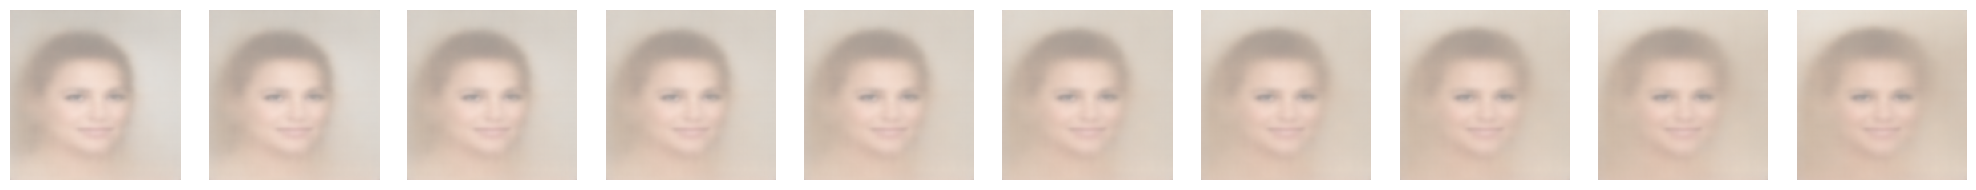

In [45]:
import torch
import matplotlib.pyplot as plt

attribute_fn = lambda idx: idx % 2 == 0

def semantic_latent_manipulation(model, dataloader, device, attribute_fn, num_images=10, steps=7, strength=2.5):
    model.eval()

    with_attr_z = []
    without_attr_z = []
    idx = 0
    for batch in dataloader:
        images = batch.to(device)

        with torch.no_grad():
            z_mean, _ = model.encode(images)

        for i in range(images.size(0)):
            if attribute_fn(idx):
                with_attr_z.append(z_mean[i].detach().cpu())
            else:
                without_attr_z.append(z_mean[i].detach().cpu())
            idx += 1
            if len(with_attr_z) >= num_images and len(without_attr_z) >= num_images:
                break
        if len(with_attr_z) >= num_images and len(without_attr_z) >= num_images:
            break

    with_attr_z = torch.stack(with_attr_z)
    without_attr_z = torch.stack(without_attr_z)
    direction = (with_attr_z.mean(dim=0) - without_attr_z.mean(dim=0)).to(device)

    base_img = next(iter(dataloader))[0].unsqueeze(0).to(device)

    with torch.no_grad():
        z_base, _ = model.encode(base_img)
        z_base = z_base.squeeze(0)

    manipulated_imgs = []
    for alpha in torch.linspace(-strength, strength, steps):
        z_mod = z_base + alpha * direction
        with torch.no_grad():
            x_recon = model.decode(z_mod.unsqueeze(0))
        img = x_recon.squeeze(0).cpu().permute(1, 2, 0)
        img = (img + 1) / 2
        manipulated_imgs.append(img.clamp(0, 1))

    fig, axes = plt.subplots(1, steps, figsize=(steps * 2, 2))
    for i, img in enumerate(manipulated_imgs):
        axes[i].imshow(img.numpy())
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

semantic_latent_manipulation(
    model=model,
    dataloader=dataloader,
    device=device,
    attribute_fn=attribute_fn,
    num_images=200,
    steps=10,
    strength=2.5
)


Metrics

In [90]:
import os
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment
import pandas as pd
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, self.image_filenames[idx]


data_path = r"E:\datasets\archive\img_align_celeba\img_align_celeba"
attr_path = r"E:\datasets\archive\list_attr_celeba.txt"

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = CelebADataset(data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

attr_df = pd.read_csv(attr_path, sep='\s+', skiprows=1)
attr_df = attr_df.reset_index().rename(columns={"index": "filename"})
attr_df["filename"] = attr_df["filename"].apply(lambda x: x.strip())

attr_name = "Male"
attr_labels = dict(zip(attr_df["filename"], (attr_df[attr_name].values + 1) // 2))

def cluster_accuracy(y_true, y_pred, num_classes):
    cost_matrix = np.zeros((num_classes, num_classes))
    for i in range(num_classes):
        for j in range(num_classes):
            cost_matrix[i, j] = np.sum((y_pred == i) & (y_true == j))
    row_ind, col_ind = linear_sum_assignment(-cost_matrix)
    mapping = dict(zip(row_ind, col_ind))
    y_aligned = np.array([mapping[y] for y in y_pred])
    return accuracy_score(y_true, y_aligned)

def evaluate_clustering(model, dataloader, attr_labels, device, max_samples=20000):
    model.eval()
    zs, all_labels = [], []
    total_processed = 0

    with torch.no_grad():
        for x, filenames in dataloader:
            if total_processed >= max_samples:
                break

            x = x.to(device)
            _, mu, _, _ = model(x)
            mu_np = mu.cpu().numpy()
            
            zs.append(mu_np)

            batch_labels = [attr_labels[fn] for fn in filenames]
            all_labels.extend(batch_labels)

            total_processed += len(filenames)

    zs = np.concatenate(zs, axis=0)[:max_samples]
    labels = np.array(all_labels)[:max_samples]
    num_classes = len(np.unique(labels))

    kmeans = KMeans(n_clusters=num_classes, n_init=10, random_state=42)
    preds = kmeans.fit_predict(zs)

    acc = cluster_accuracy(labels, preds, num_classes)
    nmi = normalized_mutual_info_score(labels, preds)

    print(f"Clustering Accuracy (on {max_samples} samples): {acc:.4f}")
    print(f" NMI Score: {nmi:.4f}")
    return acc, nmi


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

evaluate_clustering(model, dataloader, attr_labels, device)


<>:42: SyntaxWarning: invalid escape sequence '\s'
<>:42: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jai54\AppData\Local\Temp\ipykernel_18068\1518631042.py:42: SyntaxWarning: invalid escape sequence '\s'
  attr_df = pd.read_csv(attr_path, sep='\s+', skiprows=1)


Clustering Accuracy (on 20000 samples): 0.5210
 NMI Score: 0.0017


(0.52095, np.float64(0.0017417786001206516))